## The Need for Covariate Balance in Observational Studies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

Doing a regression analysis on a dataset can provide meaningful insight on the association between quantities, however identifying relationships of cause and effect among quantities requires more structure from the data and its analysis. Such structured approaches for identifying causal relationships are the subject of causal inference. Two of the most common approaches for conducting causal inference are randomized experiments and observational studies. 

Observational studies are attempts at causal explanations based on datasets that did not arise from randomized experiments. The data arise naturally, that is, without treatment and control status being randomly assigned to members of the study by the designer of the experiment. Rather, individuals freely choose whether to receive the treatment or not. After the data is collected, the analyst considers whether two main assumptions can be made about the system that generated the data. The first is whether they have collected data on all confounding variables, that is, on all pre-experiment variables that are expected to be associated with both uptake of treatment and value of the response. The second is whether there is not only overlap but also balance in the distributions of confounding variables in both treatment and control groups. Provided these conditions are met, causal statements can be identified from the data. In this lab, I simulate an experiment in which all confounding variables are measured and conditioned upon, but there is an extreme lack of balance in the covariates. My goal is to illustrate the assumption with an example and empirically demonstrate the importance of the assumption by showing how analysis fails when it is not satisfied. In a nutshell, lack of overlap forces us to overrely on our subjective choice of model for the form of the data, as demonstrated in this example by the extreme difference in fit between linear regression and k-nearest neighbors. 

The following example is based on an example in Gelman's Regression and Other Stores. In this example, treatment is offered to a population in which some people are sick, and some are not. Naturally, most of the people who seek treatment are already sick, and most of the people who do not receive treatment are already well, with only a few exceptions. We assume that pre-treatment health, represented by variable X, is responsible for all confounding. More colloquially, we assume that all individuals with similar pre-treatment health status receive treatment at the same rate and uninfluenced by each others' decisions. 

The model I use for simulating the data is as follows. The pre-experiment health status of population is simulated in two groups: a "low health" distribution $N(\text{low}, \text{spread})$ and a "high health" distribution $N(\text{high}, \text{spread})$. A small number ($\text{num main}$) in each group (high/low health) are rule-breakers, and the rest ($\text{num outliers}$) do the sensible thing of receiving treatment if they have low health and not receiving treatment if they have high health. I set $$\text{low} = 3, \\ \text{high} = 4, \\ \text{spread} = 0.3, \\ \text{num main} = 100, \\ \text{num outliers} = 5.$$ Those in the low-health group who are treated will have outcome health status set equal to $Y=3$, and those who do not will have outcome health status $Y=2$. In the high-health group, the main group of untreated individuals will have outcome health status equal to $Y=3$, and the treated ones will have outcome $Y=4$. So according to my model, the treatment effect is a constant effect of 1 across all pre-treatment health statuses. The causal model should be able to recover that constant treatment effect provided the right assumptions about the data are true. However, we will observe that the lack of overlap makes the causal effect difficult to identify, forcing us to over-rely on the form of our model, making our estimate extremely sensitive to our subjective choice of which model to use, thus preventing us from uncovering a meaningful effect. 

In [2]:
np.random.seed(42)

num_main = 100
num_outliers = 5 # the number of rule breakers in each class
spread = 0.3
X_low = np.random.normal(3, spread, num_main + num_outliers)
Y_low = np.concatenate((np.repeat(4, num_main), np.repeat(3, num_outliers)))
X_high = np.random.normal(4, spread, num_main + num_outliers)
Y_high = np.concatenate((np.repeat(4, num_main), np.repeat(5, num_outliers)))

In [3]:
low = pd.DataFrame({'Group': np.concatenate((np.repeat(1, num_main), np.repeat(0,num_outliers))), 'X': X_low, 'Y': Y_low})
high = pd.DataFrame({'Group': np.concatenate((np.repeat(0, num_main), np.repeat(1,num_outliers))), 'X': X_high, 'Y': Y_high})
data = pd.concat([low, high], ignore_index=True)

An example of some entries in the dataset. These entries include both individuals who received treatment (Group 1) and individuals who did not (Group 0), however all the pictured data lie in the high health region. 

In [4]:
data[-10:]

,Group,X,Y
200,0,4.107336,4
201,0,4.168235,4
202,0,4.324915,4
203,0,4.316141,4
204,0,3.586699,4
205,1,3.718652,5
206,1,4.154511,5
207,1,4.154136,5
208,1,4.154514,5
209,1,5.155819,5


If we fit a linear model to these data, we will not recover the true treatment effect of $\tau = 1$. 

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


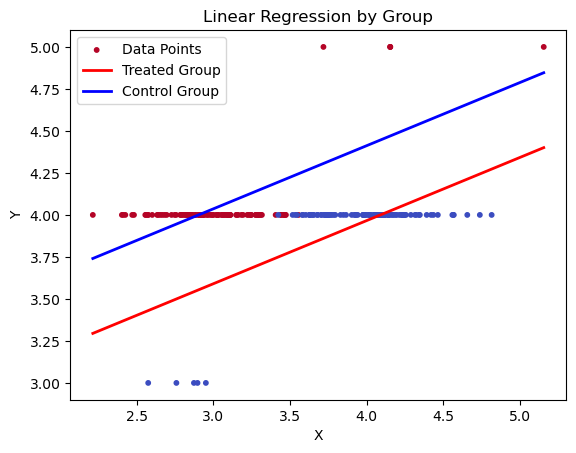

In [5]:
model = LinearRegression()
model.fit(data[['X', 'Group']], data['Y'])

plt.figure()
plt.scatter(data['X'], data['Y'], c=data['Group'], cmap='coolwarm', s=10, label='Data Points')
x_range = np.linspace(data['X'].min(), data['X'].max(), 100)
y_treated = model.predict(np.column_stack((x_range, np.zeros_like(x_range))))
y_control = model.predict(np.column_stack((x_range, np.ones_like(x_range))))
plt.plot(x_range, y_treated, color='red', label='Treated Group', linewidth=2)
plt.plot(x_range, y_control, color='blue', label='Control Group', linewidth=2)
plt.title('Linear Regression by Group')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [6]:
print("The coefficient of treatment status, and thus the estimated treatment effect, is ") 
print(model.coef_[1])

The coefficient of treatment status, and thus the estimated treatment effect, is 
0.44587053556396583


The coefficient is much lower than the true effect of 1. This is because estimation of treatment effect according to the linear model overrelies on the assumption of linearity of the form of the underlying data. This is demonstrated by fitting a k-NN model, which is able to better adapt to the structure of our data. 

In [7]:
knn_model_treated = KNeighborsRegressor(n_neighbors=1)
knn_model_treated.fit(data[data['Group'] == 1]['X'].values.reshape(-1, 1), data[data['Group'] == 1]['Y'])
knn_model_control = KNeighborsRegressor(n_neighbors=1)
knn_model_control.fit(data[data['Group'] == 0]['X'].values.reshape(-1, 1), data[data['Group'] == 0]['Y'])

KNeighborsRegressor(n_neighbors=1)

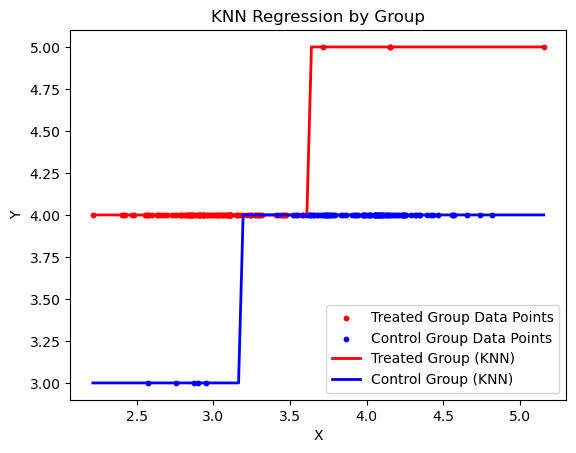

In [8]:
plt.figure()
plt.scatter(data[data['Group'] == 1]['X'], data[data['Group'] == 1]['Y'], c='red', s=10, label='Treated Group Data Points')
plt.scatter(data[data['Group'] == 0]['X'], data[data['Group'] == 0]['Y'], c='blue', s=10, label='Control Group Data Points')
x_range = np.linspace(data['X'].min(), data['X'].max(), 100)
y_treated_knn = knn_model_treated.predict(x_range.reshape(-1, 1))
y_control_knn = knn_model_control.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_treated_knn, color='red', label='Treated Group (KNN)', linewidth=2)
plt.plot(x_range, y_control_knn, color='blue', label='Control Group (KNN)', linewidth=2)
plt.title('KNN Regression by Group')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Observe that the k-NN model estimates a treatment effect of 1 over almost the entire region of the data. Thus, the linear regression estimate overrelies on the assumption of linearity of the underlying data generating mechanism in this case. And moreover, the estimated treatment effect is highly sensitive to our choice of model, which is subjective. This example thus demonstrates that it is practically impossible to accurately estimate the treatment effect in the case where there is a lack of overlap among the covariate distributions of treatment and control groups. 